## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [208]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [209]:
# ваш код здесь
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
None


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [229]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
daily_data = data.groupby(['date', 'group']).agg({
    'purchase':'sum',
    'price':'sum'
}).reset_index()
print(daily_data.iloc[0].date)
print(daily_data.iloc[len(daily_data) - 1].date)

2021-01-02 00:00:00
2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [211]:
# ваш код здесь
print(data[data['group'] == 'A']['purchase'].count())
print(data[data['group'] == 'B']['purchase'].count())
print(daily_data[daily_data['group'] == 'A']['purchase'].sum())
print(daily_data[daily_data['group'] == 'B']['purchase'].sum())
print(daily_data[daily_data['group'] == 'A']['price'].sum() / 1000000)
print(daily_data[daily_data['group'] == 'B']['price'].sum() / 1000000)

147202
147276
17723
17514
1436.26
1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [212]:
# ваш код здесь
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = set_a.intersection(set_b)
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [213]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
print(updated_data)

        user_id       date group  purchase   price
0        851104 2021-01-21     A         0       0
1        804228 2021-01-12     A         0       0
2        661590 2021-01-11     B         0       0
3        853541 2021-01-08     B         0       0
4        864975 2021-01-21     A         1  150000
...         ...        ...   ...       ...     ...
294473   751197 2021-01-03     A         0       0
294474   945152 2021-01-12     A         0       0
294475   734608 2021-01-22     A         0       0
294476   697314 2021-01-15     A         0       0
294477   715931 2021-01-16     B         0       0

[290688 rows x 5 columns]


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

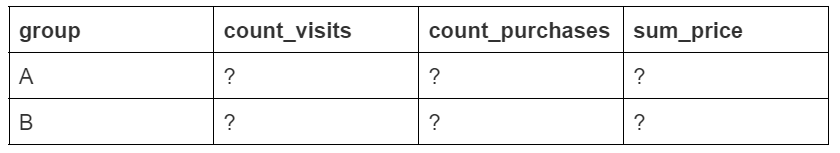
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [232]:
# ваш код здесь
updated_data['count_visits'] = updated_data['purchase'].copy()
data2 = updated_data.groupby(['group']).agg({
    'purchase':'sum',
    'price':'sum',
    'count_visits':'count'
}).reset_index().rename(columns={'purchase': 'count_purchases', 'price': 'sum_price'})
print(data2)
daily_data = updated_data.groupby(['date', 'group']).agg({
    'purchase':'sum',
    'price':'sum'
}).reset_index()

  group  count_purchases   sum_price  count_visits
0     A            17487  1417780000        145307
1     B            17290  1533010000        145381


/tmp/ipykernel_15308/2031651721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_data['count_visits'] = updated_data['purchase'].copy()


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

я думаю, что да количество посещений обоих вариантов сопоставимо, так как количество посещений и количество покупок примерно одинаково.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [215]:
# ваш код здесь
data2['conversion'] = data2['count_purchases'] / data2['count_visits'] * 100
data2['mean_check'] = data2['sum_price'] / data2['count_purchases']
print(data2)

  group  count_purchases   sum_price  count_visits  conversion    mean_check
0     A            17487  1417780000        145307   12.034520  81076.228055
1     B            17290  1533010000        145381   11.892888  88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия покупок в процентах в группе А больше и это показывает, что в группе А происходит больше покупок. Но в группе Б средний чек ощутимо больше, поэтому хоть там покупки происходят реже, но сразу на более большую сумму в среднем, чем в группе А. 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [216]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

group
A    5271
B    1730
Name: 60000, dtype: int64


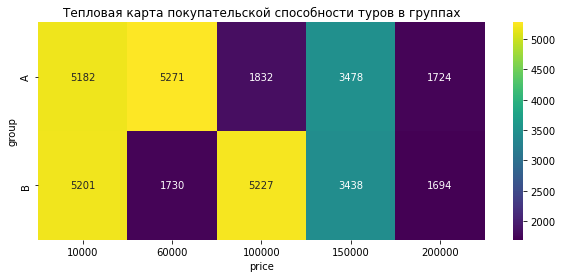

In [217]:
# ваш код здесь
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах');
print(pivot[60000])

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

При цене 60000 рублей в группе А покупательская способность выше, чем в группе Б, но такое обратное событие наблюдается и при цене 100000.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [218]:
# ваш код здесь
cdata = updated_data.groupby(['date', 'group']).agg({
    'purchase':'sum',
    'price':'sum',
    'count_visits':'count'
}).reset_index().rename(columns={'purchase': 'count_purchases', 'price': 'sum_price'})
cdata['conversion'] = cdata['count_purchases'] / cdata['count_visits'] * 100
cdata['mean_check'] = cdata['sum_price'] / cdata['count_purchases']
display(round(cdata[cdata['date'] == pd.to_datetime('2021-01-03')], 2))


,date,group,count_purchases,sum_price,count_visits,conversion,mean_check
2,2021-01-03,A,748,62000000,6596,11.34,82887.70
3,2021-01-03,B,754,65960000,6619,11.39,87480.11


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [219]:
# ваш код здесь
cdata['cum_count_visits'] = cdata.groupby('group')['count_visits'].cumsum()
cdata['cum_count_purchases'] = cdata.groupby('group')['count_purchases'].cumsum()
cdata['cum_sum_price'] = cdata.groupby('group')['sum_price'].cumsum()
cdata['cum_conversion'] = cdata['cum_count_purchases'] / cdata['cum_count_visits'] * 100
cdata['cum_mean_check'] = cdata['cum_sum_price'] / cdata['cum_count_purchases']
display(round(cdata[cdata['date'] == pd.to_datetime('2021-01-20')], 2))
display(round(cdata[cdata['date'] == pd.to_datetime('2021-01-12')], 2))

,date,group,count_purchases,sum_price,count_visits,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
36,2021-01-20,A,749,58710000,6533,11.46,78384.51,121506,14561,1179590000,11.98,81010.23
37,2021-01-20,B,790,69250000,6685,11.82,87658.23,121857,14496,1286900000,11.90,88776.21


,date,group,count_purchases,sum_price,count_visits,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
20,2021-01-12,A,795,68460000,6540,12.16,86113.21,68852,8198,668070000,11.91,81491.83
21,2021-01-12,B,807,70560000,6635,12.16,87434.94,69251,8236,727670000,11.89,88352.36


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

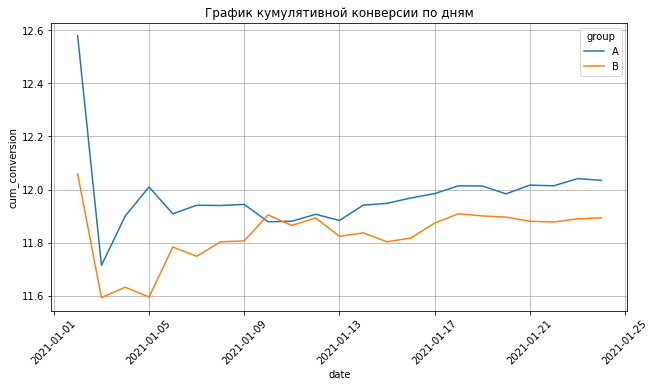

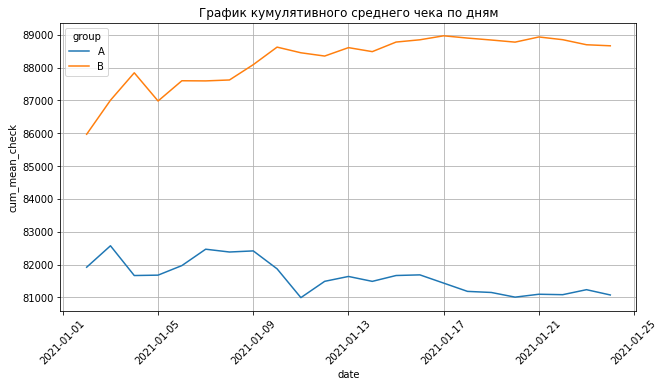

In [220]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=cdata, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=cdata, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

Думаю, что A/B тестирование считается завершенным, так как значения обоих метрик стабилизировались со временем. Даже если кумулятивная конверсия в группе А выше, но кумулятивный средний чек намного меньше чем в группе Б.  

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [221]:
# ваш код здесь 
# так как тут мы считаем равенство конверсий, нужно использовать proportions_ztest
# определим нулевую и альтернативную гипотезы 
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B (Мы отвергаем H0).'
alpha = 0.05
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)
_, p_value = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'], 
    alternative='larger',
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


,sum,count
group,,
A,17487,145307
B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Полученная разница в метрике в группах статистически не значима, поэтому они одинаково эффективны по метрике конверсии.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [222]:
# ваш код здесь
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'B']['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

n = [updated_data[updated_data['group'] == 'A']['user_id'].count(), updated_data[updated_data['group'] == 'B']['user_id'].count()]
xp = [updated_data[updated_data['group'] == 'A']['purchase'].mean(), updated_data[updated_data['group'] == 'B']['purchase'].mean()]
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике, так как доверительный интервал для разности конверсий охватывает точку 0.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [239]:
# ваш код здесь
# будем использовать тест Шапиро-Уилка для проверки гипотезы о нормальности распределения ежедневного среднего чека
H0 = 'Распределение нормальное'
H1 = 'Распределение отлично от нормального (Мы отвергаем H0).'
alpha = 0.05
daily_data['mean_check'] = daily_data['price'] / daily_data['purchase']
a_group = daily_data[daily_data['group'] == 'A']['mean_check']
b_group = daily_data[daily_data['group'] == 'B']['mean_check']
_, p = shapiro(a_group)
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(H1)
 
_, p = shapiro(b_group)
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(H1)
 
# Распределение в обоих группах является нормальным 

p=0.253
Распределение нормальное
p=0.094
Распределение нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [240]:
# ваш код здесь
# так как данные распределены нормально в обоих случаях, нужно воспользоваться Т-тестом
H0 = 'Ежедневные средние чеки в группах А и B равны;'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
alpha = 0.05
test_results = ttest_ind(a_group, b_group, equal_var=True)
p = round(test_results[1], 2)
if p > alpha:
    print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}")

0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Со статистической точки зрения существует ощутимая разница между ежедневными средними чеками в группах A и B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [241]:
# ваш код здесь

def X(n, k, x_mean, x_std, gamma, alpha):
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат


X(len(a_group), len(a_group) - 1, a_group.mean(), a_group.std(), 0.95, 0.05)
X(len(b_group), len(b_group) - 1, b_group.mean(), b_group.std(), 0.95, 0.05)

Доверительный интервал: (79630, 82308)
Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечений между доверительными интервалами для ежедневных средних чеков в группах нет. То есть истинный средний чек обоих групп лежит в разных интервалах и они по любому не будут равны.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Сначала проанализируем со стороны метрики конверсии. Выдвинув нулевую и альтернативные гипотезы по конверсиям, с помощью Z-test мы выяснили, что статистически конверсии одинаково эффективны. Смотря на средний чек, также через нулевую и альтернативные гипотезы, используя T-test видно, что существует ощутимая разница между группами. В группе средний чек меньше, чем в группе Б и смотря между доверительными интервалами среднего чека, то даже минимальное среднее значение чека в группе Б намного больше чем максимальное среднее значение чека в группе А (82308 и 87626). Поэтому тестовая группа Б считается более эффективной, чем контрольная группа А.